In [ ]:
!pip install pandas openpyxl scikit-learn matplotlib seaborn tensorflow --quiet

In [ ]:
from google.colab import files
uploaded = files.upload()  # Select your .xlsx files when prompted

Saving Copy of catalog-2020-21(1).xlsx to Copy of catalog-2020-21(1).xlsx
Saving Pragpar_30Minutes.xlsx to Pragpar_30Minutes.xlsx


✅ Label distribution:
 0    1054
1     345
Name: count, dtype: int64

✅ Applying SMOTE...
Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5824 - loss: 0.6653 - val_accuracy: 0.7156 - val_loss: 0.5865
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7367 - loss: 0.5699 - val_accuracy: 0.7464 - val_loss: 0.5371
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7781 - loss: 0.5031 - val_accuracy: 0.7607 - val_loss: 0.5108
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7936 - loss: 0.4608 - val_accuracy: 0.7773 - val_loss: 0.4954
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7971 - loss: 0.4309 - val_accuracy: 0.7962 - val_loss: 0.4812
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8149 - loss: 0.4147 - val_accuracy: 0.8033 - val_loss: 0.4611
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8218 - loss: 0.3884 - val_accuracy: 0.8057 - val_loss: 0.4469
Epoch 8/20
53/53 ━━━━━━━━━━━

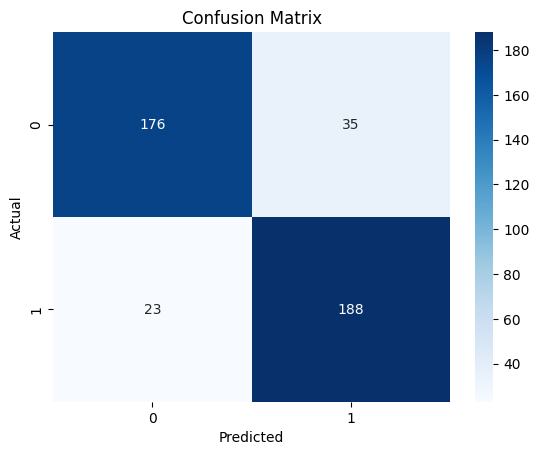

In [ ]:
# === SETUP ===

# === IMPORTS ===
import pandas as pd
import numpy as np
from datetime import timedelta
from scipy.stats import skew
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

from imblearn.over_sampling import SMOTE

# === LOAD FILES ===
pragpar_df = pd.read_excel("Pragpar_30Minutes.xlsx")
catalog_df = pd.read_excel("Copy of catalog-2020-21(1).xlsx")

# === PARSE DATES ===
pragpar_df['Time'] = pd.to_datetime(pragpar_df['Time'], dayfirst=True, errors='coerce')
catalog_df['Datetime'] = pd.to_datetime(catalog_df[['Year', 'Month', 'Day', 'Hour', 'Minute', 'Second']], errors='coerce')

pragpar_df.dropna(subset=['Time'], inplace=True)
catalog_df.dropna(subset=['Datetime'], inplace=True)

# === CREATE ±3 DAY WINDOWS FOR EACH EARTHQUAKE ===
quake_windows = []
for dt in catalog_df['Datetime']:
    quake_windows.append((dt - timedelta(days=3), dt + timedelta(days=3)))

# === SLIDING WINDOW FUNCTION ===
def extract_window_features(df, window_size=48, step=48):
    features = []
    labels = []
    times = []

    for start in range(0, len(df) - window_size + 1, step):
        window = df.iloc[start:start + window_size]
        end_time = window['Time'].iloc[-1]

        # Extract features
        f = {}
        for col in ['Radon(Bq/m3)', 'Temperature (°C)', 'Pressure (mBar)', 'Humidity (%)', 'Windspeed (Km/hr)']:
          series = window[col].values
          f[f'{col}_mean'] = np.mean(series)
          f[f'{col}_std'] = np.std(series)
          f[f'{col}_skew'] = skew(series)
          f[f'{col}_min'] = np.min(series)
          f[f'{col}_max'] = np.max(series)
          f[f'{col}_range'] = np.max(series) - np.min(series)
          f[f'{col}_q25'] = np.percentile(series, 25)
          f[f'{col}_q75'] = np.percentile(series, 75)
          f[f'{col}_iqr'] = f[f'{col}_q75'] - f[f'{col}_q25']
          f[f'{col}_last'] = series[-1]
          f[f'{col}_first'] = series[0]
          f[f'{col}_delta'] = series[-1] - series[0]

        # Label: 1 if window overlaps with any ±3d quake window
        label = 0
        for qstart, qend in quake_windows:
            if (window['Time'].iloc[0] <= qend) and (end_time >= qstart):
                label = 1
                break

        features.append(f)
        labels.append(label)
        times.append(end_time)

    return pd.DataFrame(features), pd.Series(labels), pd.Series(times)

# === EXTRACT FEATURES AND LABELS ===
features_df, labels, window_times = extract_window_features(pragpar_df, window_size=36, step=12)



print("✅ Label distribution:\n", labels.value_counts())

# === SCALING ===
scaler = RobustScaler()
X_scaled = scaler.fit_transform(features_df)
y = labels.values

# === SMOTE (if needed) ===
if np.sum(y) > 0 and np.sum(y == 0) > 0:
    print("\n✅ Applying SMOTE...")
    sm = SMOTE(random_state=42)
    X_resampled, y_resampled = sm.fit_resample(X_scaled, y)
else:
    print("\n⚠️ No anomalies or only one class found. Skipping SMOTE.")
    X_resampled, y_resampled = X_scaled, y

# === SPLIT ===
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in sss.split(X_resampled, y_resampled):
    X_train, X_test = X_resampled[train_idx], X_resampled[test_idx]
    y_train, y_test = y_resampled[train_idx], y_resampled[test_idx]

# === CLASS WEIGHTS ===
cw = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(cw))

# === DEFINE FFNN ===
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

# === TRAIN ===
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    class_weight=class_weights,
    verbose=1
)

# === EVALUATE ===
y_pred = (model.predict(X_test) > 0.5).astype(int)
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# === CONFUSION MATRIX ===
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


/tmp/ipython-input-9-2780717486.py:28: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


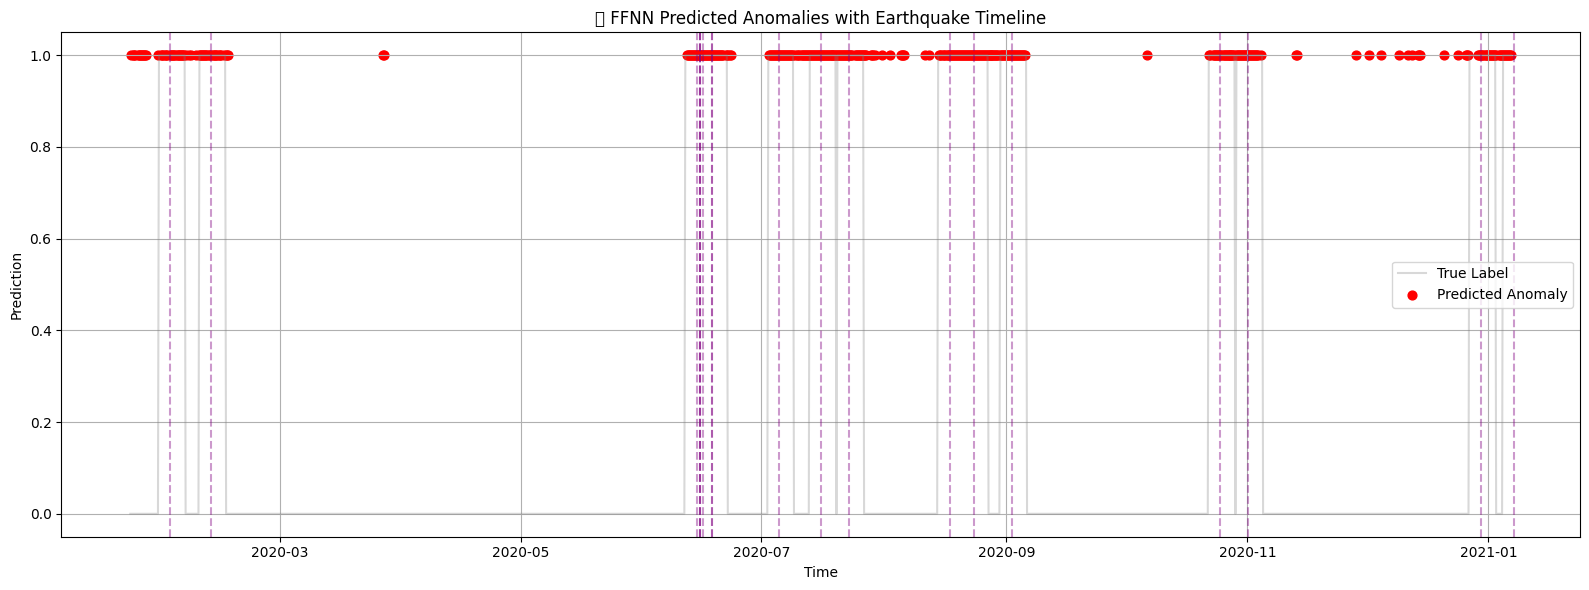

In [ ]:
# === PREDICT OVER ALL WINDOWS (Not just test set) ===
all_X_scaled = scaler.transform(features_df)
all_preds = (model.predict(all_X_scaled) > 0.5).astype(int).flatten()

# Store predictions with timestamps
result_df = pd.DataFrame({
    'Window_End_Time': window_times,
    'Predicted_Label': all_preds,
    'True_Label': labels.values
})

# === PLOT PREDICTIONS ON TIME ===
plt.figure(figsize=(16, 6))
plt.plot(result_df['Window_End_Time'], result_df['True_Label'], label='True Label', alpha=0.3, color='gray')
plt.scatter(result_df['Window_End_Time'][result_df['Predicted_Label'] == 1],
            result_df['Predicted_Label'][result_df['Predicted_Label'] == 1],
            color='red', label='Predicted Anomaly', s=40)

# Plot earthquake dates as vertical lines
for qtime in catalog_df['Datetime']:
    plt.axvline(qtime, color='purple', linestyle='--', alpha=0.4)

plt.title("🧠 FFNN Predicted Anomalies with Earthquake Timeline")
plt.xlabel("Time")
plt.ylabel("Prediction")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# === Predict on ALL windows ===
all_preds = (model.predict(X_scaled) > 0.5).astype(int).flatten()

# Add predictions to the dataframe
features_df['Anomaly'] = all_preds
features_df['Window_End_Time'] = window_times


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
# === Filter anomalous windows ===
anomalies = features_df[features_df['Anomaly'] == 1]

print(f"⚠️ Total anomalous windows detected: {len(anomalies)}")
print("\n📅 Anomalous time windows (end times):")
print(anomalies[['Window_End_Time']].head(10))  # Show first 10 anomalous windows


⚠️ Total anomalous windows detected: 393

📅 Anomalous time windows (end times):
       Window_End_Time
1  2020-01-23 11:20:00
3  2020-01-23 23:20:00
4  2020-01-24 05:20:00
5  2020-01-24 11:20:00
8  2020-01-25 05:20:00
9  2020-01-25 11:20:00
10 2020-01-25 17:20:00
11 2020-01-25 23:20:00
12 2020-01-26 05:20:00
13 2020-01-26 11:20:00


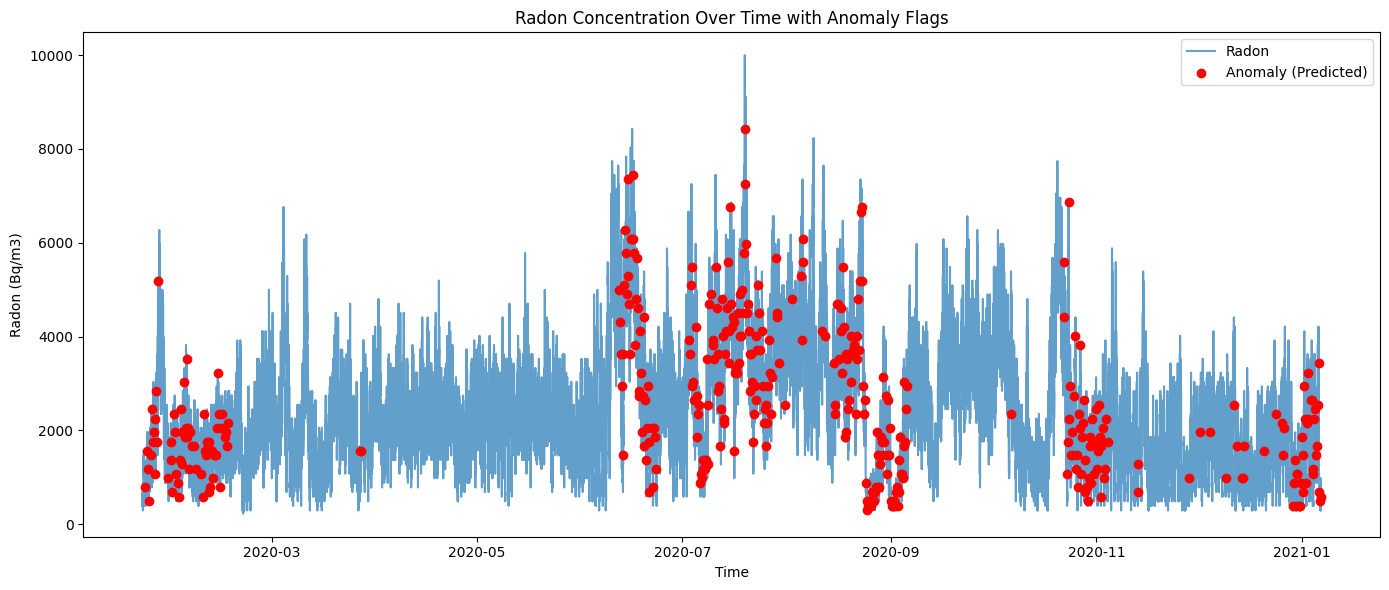

In [ ]:
# Merge flags back to main dataframe for plotting
pragpar_df['Anomaly'] = 0
for t in anomalies['Window_End_Time']:
    pragpar_df.loc[pragpar_df['Time'] == t, 'Anomaly'] = 1

# === Plotting ===
plt.figure(figsize=(14,6))
plt.plot(pragpar_df['Time'], pragpar_df['Radon(Bq/m3)'], label='Radon', alpha=0.7)
plt.scatter(pragpar_df[pragpar_df['Anomaly']==1]['Time'],
            pragpar_df[pragpar_df['Anomaly']==1]['Radon(Bq/m3)'],
            color='red', label='Anomaly (Predicted)', zorder=5)
plt.title("Radon Concentration Over Time with Anomaly Flags")
plt.xlabel("Time")
plt.ylabel("Radon (Bq/m3)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Mark predicted anomalies that overlap with real quakes
anomalies['Is_Near_Earthquake'] = 0
for i, row in anomalies.iterrows():
    for qstart, qend in quake_windows:
        if qstart <= row['Window_End_Time'] <= qend:
            anomalies.at[i, 'Is_Near_Earthquake'] = 1
            break

# How many predicted anomalies actually occur near earthquakes?
hits = anomalies['Is_Near_Earthquake'].sum()
total = len(anomalies)

print(f"🎯 {hits}/{total} predicted anomalies fall within ±3 days of real earthquakes.")


🎯 280/393 predicted anomalies fall within ±3 days of real earthquakes.


/tmp/ipython-input-14-30353504.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies['Is_Near_Earthquake'] = 0


In [ ]:
anomalies.to_excel("Predicted_Anomalous_Windows.xlsx", index=False)

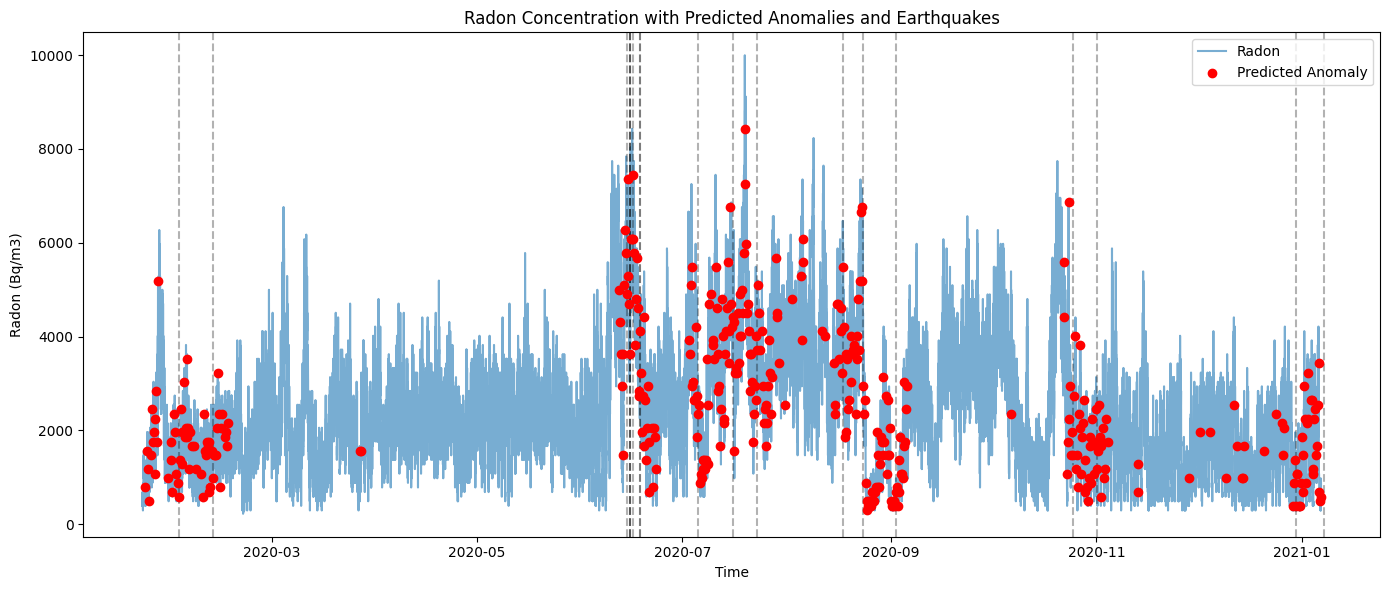

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(pragpar_df['Time'], pragpar_df['Radon(Bq/m3)'], label='Radon', alpha=0.6)

# Red dots = anomaly
plt.scatter(pragpar_df[pragpar_df['Anomaly']==1]['Time'],
            pragpar_df[pragpar_df['Anomaly']==1]['Radon(Bq/m3)'],
            color='red', label='Predicted Anomaly', zorder=5)

# Vertical lines for earthquakes
for eq_time in catalog_df['Datetime']:
    plt.axvline(eq_time, color='black', linestyle='--', alpha=0.3)

plt.title("Radon Concentration with Predicted Anomalies and Earthquakes")
plt.xlabel("Time")
plt.ylabel("Radon (Bq/m3)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Thresholds for filtering (tune these based on your domain knowledge or visualize distributions)
TEMP_STD_THRESHOLD = 2.5
PRES_STD_THRESHOLD = 1.5

# Copy anomalies and remove those with extreme weather variability
filtered_anomalies = anomalies.copy()

# Drop if temperature or pressure std is too high
filtered_anomalies = filtered_anomalies[
    (filtered_anomalies['Temperature (°C)_std'] < TEMP_STD_THRESHOLD) &
    (filtered_anomalies['Pressure (mBar)_std'] < PRES_STD_THRESHOLD)
]

print(f"✅ After filtering: {len(filtered_anomalies)} anomalies remain (from {len(anomalies)} originally).")


✅ After filtering: 362 anomalies remain (from 393 originally).


In [ ]:
# Sort anomalies by time
filtered_anomalies = filtered_anomalies.sort_values('Window_End_Time').reset_index(drop=True)

# Cluster anomalies into predicted earthquake events (within 2 days of each other)
predicted_eq_dates = []
prev_time = None
for current_time in filtered_anomalies['Window_End_Time']:
    if not prev_time or (current_time - prev_time) > pd.Timedelta(days=2):
        predicted_eq_dates.append(current_time)
    prev_time = current_time

print(f"🔮 Total predicted earthquake dates: {len(predicted_eq_dates)}")


🔮 Total predicted earthquake dates: 19


In [ ]:
tp = 0  # true positives
fp = 0  # false positives
fn = 0  # false negatives

# Match each predicted anomaly window with EQ ±3 days
matched_quakes = set()
for t in filtered_anomalies['Window_End_Time']:
    match = False
    for i, eq_time in enumerate(catalog_df['Datetime']):
        if abs((t - eq_time).days) <= 3:
            tp += 1
            matched_quakes.add(i)
            match = True
            break
    if not match:
        fp += 1

# Now count earthquakes with no matching anomalies = FN
total_quakes = len(catalog_df)
fn = total_quakes - len(matched_quakes)

precision = tp / (tp + fp) if (tp + fp) else 0
recall = tp / (tp + fn) if (tp + fn) else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

print(f"✅ True Positives (TP): {tp}")
print(f"❌ False Positives (FP): {fp}")
print(f"⚠️ False Negatives (FN): {fn}\n")

print(f"🎯 Precision: {precision:.2f}")
print(f"📈 Recall:    {recall:.2f}")
print(f"🏁 F1 Score:  {f1:.2f}")


✅ True Positives (TP): 286
❌ False Positives (FP): 76
⚠️ False Negatives (FN): 3

🎯 Precision: 0.79
📈 Recall:    0.99
🏁 F1 Score:  0.88


/tmp/ipython-input-21-2597743003.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_anomalies['Match'] = 'Unmatched'


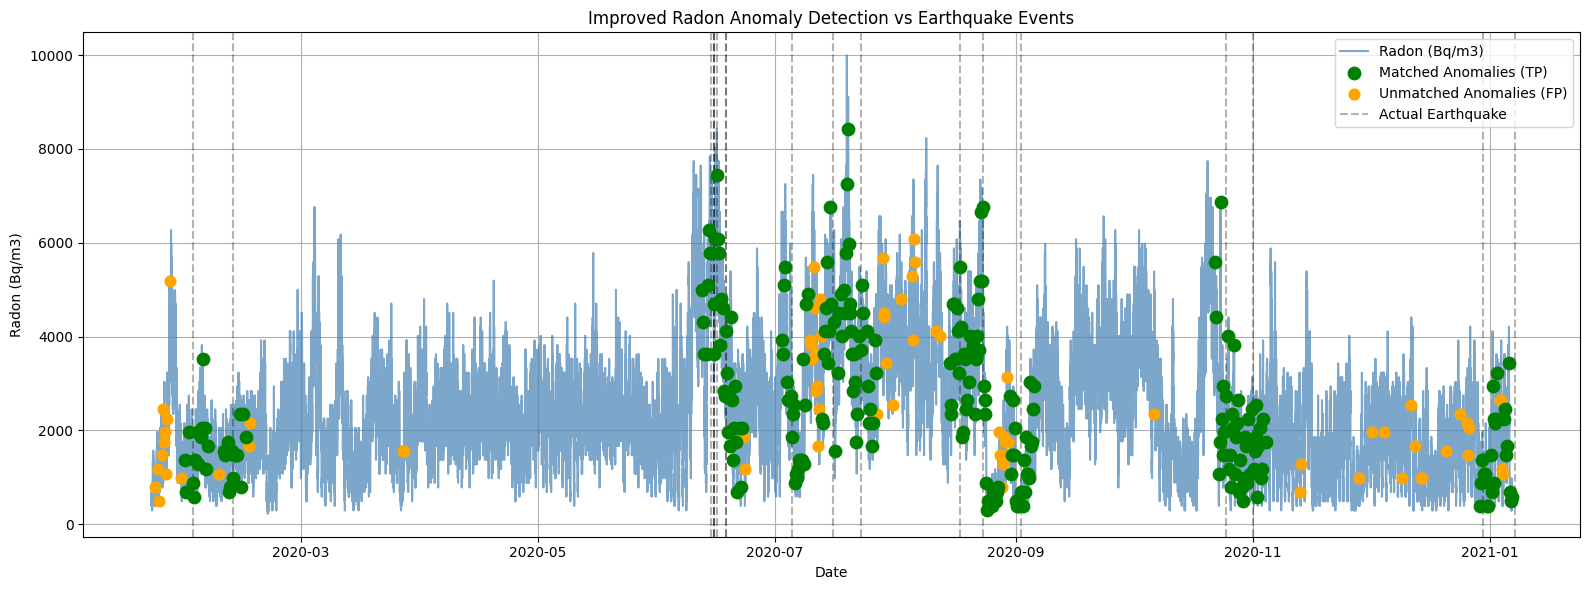

✅ True Positives (TP): 270
❌ False Positives (FP): 73
⚠️ False Negatives (FN): 0
🎯 Precision: 78.72%
📈 Recall:    100.00%
🏁 F1 Score:  88.09%


In [ ]:
# === Enhanced Evaluation Block ===

import matplotlib.pyplot as plt

# 1. SNAP anomaly times to nearest Radon time (more accurate matching)
# === Already present ===
filtered_anomalies = filtered_anomalies.copy()
filtered_anomalies['Window_End_Time_Snapped'] = filtered_anomalies['Window_End_Time'].apply(
    lambda t: pragpar_df['Time'].iloc[(pragpar_df['Time'] - t).abs().argsort()[0]]
)

# === ✅ STEP 4: Filter weak anomalies based on Radon delta ===
filtered_anomalies['Radon_Δ'] = filtered_anomalies['Radon(Bq/m3)_delta']
filtered_anomalies = filtered_anomalies[filtered_anomalies['Radon_Δ'].abs() > 20]  # Tune threshold as needed

eq_times = catalog_df['Datetime']
anomaly_times = filtered_anomalies['Window_End_Time_Snapped']

# 2. Match anomalies to EQs for Precision
filtered_anomalies['Match'] = 'Unmatched'
matched_quakes = set()

for idx, row in filtered_anomalies.iterrows():
    anomaly_time = row['Window_End_Time_Snapped']
    for i, eq_time in enumerate(eq_times):
        if abs((anomaly_time - eq_time).days) <= 3:
            filtered_anomalies.at[idx, 'Match'] = 'Matched'
            matched_quakes.add(i)
            break

# 3. Match EQs to anomalies for Recall
matched_eqs = []
unmatched_eqs = []

for eq_time in eq_times:
    found = False
    for t in anomaly_times:
        if abs((eq_time - t).days) <= 3:
            matched_eqs.append(eq_time)
            found = True
            break
    if not found:
        unmatched_eqs.append(eq_time)

# 4. Compute Metrics
tp = len(filtered_anomalies[filtered_anomalies['Match'] == 'Matched'])
fp = len(filtered_anomalies[filtered_anomalies['Match'] == 'Unmatched'])
fn = len(unmatched_eqs)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# 5. Plot
matched = filtered_anomalies[filtered_anomalies['Match'] == 'Matched']
unmatched = filtered_anomalies[filtered_anomalies['Match'] == 'Unmatched']

plt.figure(figsize=(16,6))
plt.plot(pragpar_df['Time'], pragpar_df['Radon(Bq/m3)'], label='Radon (Bq/m3)', color='steelblue', alpha=0.7)

# Matched anomalies
plt.scatter(matched['Window_End_Time_Snapped'],
            [pragpar_df.iloc[(pragpar_df['Time'] - t).abs().argsort()[0]]['Radon(Bq/m3)'] for t in matched['Window_End_Time_Snapped']],
            color='green', s=80, label='Matched Anomalies (TP)', zorder=5)

# Unmatched anomalies
plt.scatter(unmatched['Window_End_Time_Snapped'],
            [pragpar_df.iloc[(pragpar_df['Time'] - t).abs().argsort()[0]]['Radon(Bq/m3)'] for t in unmatched['Window_End_Time_Snapped']],
            color='orange', s=60, label='Unmatched Anomalies (FP)', zorder=4)

# Actual earthquake times
for i, eq_time in enumerate(eq_times):
    plt.axvline(eq_time, color='black', linestyle='--', alpha=0.3, label='Actual Earthquake' if i == 0 else "")

plt.title("Improved Radon Anomaly Detection vs Earthquake Events")
plt.xlabel("Date")
plt.ylabel("Radon (Bq/m3)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 6. Final Results
print(f"✅ True Positives (TP): {tp}")
print(f"❌ False Positives (FP): {fp}")
print(f"⚠️ False Negatives (FN): {fn}")
print(f"🎯 Precision: {precision*100:.2f}%")
print(f"📈 Recall:    {recall*100:.2f}%")
print(f"🏁 F1 Score:  {f1*100:.2f}%")
